In [86]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential , Model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout , BatchNormalization 
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras.applications import VGG16 , InceptionV3 , Xception
from sklearn.metrics import classification_report, confusion_matrix


import warnings
warnings.filterwarnings("ignore")

In [67]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

In [68]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

In [69]:
class_names = os.listdir(train_dir)
class_names

['pituitary', 'notumor', 'meningioma', 'glioma']

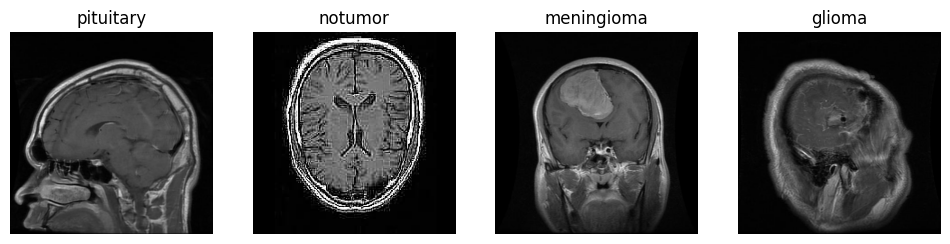

In [70]:
def plot_images(class_names):
    plt.figure(figsize = (12,12))
    
    for i, category in enumerate(class_names):
        image_path = train_dir + '/' + category
        images_in_folder = os.listdir(image_path)
        
        first_image = images_in_folder[0]
        first_image_path = image_path + '/' + first_image
        
        img = image.load_img(first_image_path)
        img_array = image.img_to_array(img) / 255
        
        plt.subplot(1,4, i+1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')
    plt.show()
plot_images(class_names)

In [74]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical")

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical")

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [82]:
model = models.Sequential()


# input layer
model.add(Conv2D(32, (4, 4), activation="relu",input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))) #using relu as the activation function
model.add(MaxPooling2D(pool_size=(3, 3)))

# hidden layers
model.add(Conv2D(64, (4, 4), activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(128, (4, 4), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(128, (4, 4), activation="relu"))
model.add(Flatten()) #used to convert the output from the last convolutional layer into a one-dimensional array that can be passed to the fully connected layers

# output layer
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation="softmax")) #4 -> number of classes

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_106 (Conv2D)             │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 46, 46, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [84]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [85]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 249ms/step - accuracy: 0.5194 - loss: 1.0127 - val_accuracy: 0.7231 - val_loss: 0.6283
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 224ms/step - accuracy: 0.7824 - loss: 0.5380 - val_accuracy: 0.7849 - val_loss: 0.5570
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 224ms/step - accuracy: 0.8456 - loss: 0.4177 - val_accuracy: 0.8162 - val_loss: 0.5356
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 223ms/step - accuracy: 0.8757 - loss: 0.3252 - val_accuracy: 0.8490 - val_loss: 0.3615
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 226ms/step - accuracy: 0.8998 - loss: 0.2648 - val_accuracy: 0.8833 - val_loss: 0.2900
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 228ms/step - accuracy: 0.9195 - loss: 0.2137 - val_accuracy: 0.8993 - val_loss: 0.2805
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 223ms/step - accuracy: 0.9378 - loss: 0.1687 - val_accuracy: 0.9191 - val_loss: 0.2118
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 223ms/step - accuracy: 0.9549 - loss: 0

In [106]:
model.save('brain_tumor_modelCNN_98%.h5')

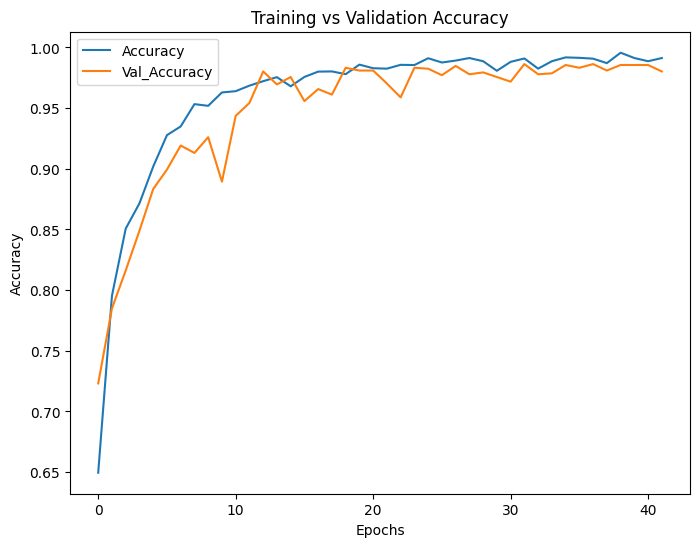

In [108]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

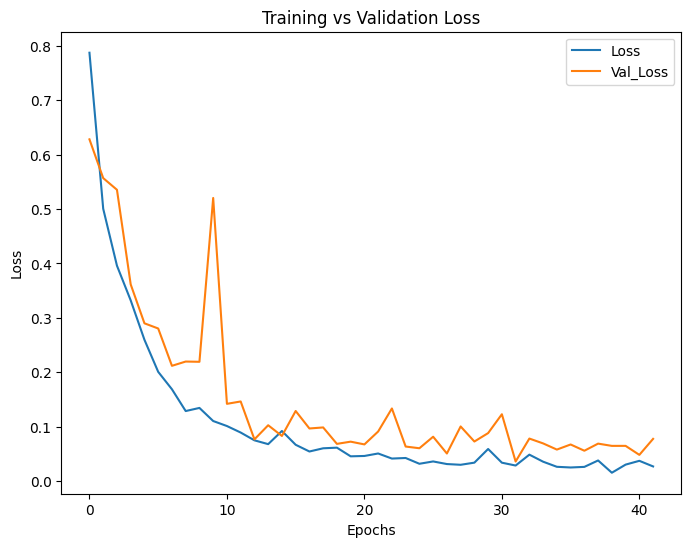

In [107]:
# 2. Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [94]:
# Generate predictions for training and validation datasets
test_predictions = model.predict(test_generator, verbose=1)

# Convert predictions to class labels
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Convert the true labels to class labels
test_true_labels = test_generator.classes

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step


In [95]:
# Classification report for validation set
print("Testing Classification Report:")
print(classification_report(test_true_labels, test_predictions_classes, target_names=class_names))

Testing Classification Report:
              precision    recall  f1-score   support

   pituitary       1.00      0.95      0.97       300
     notumor       0.95      0.97      0.96       306
  meningioma       0.99      1.00      0.99       405
      glioma       0.99      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



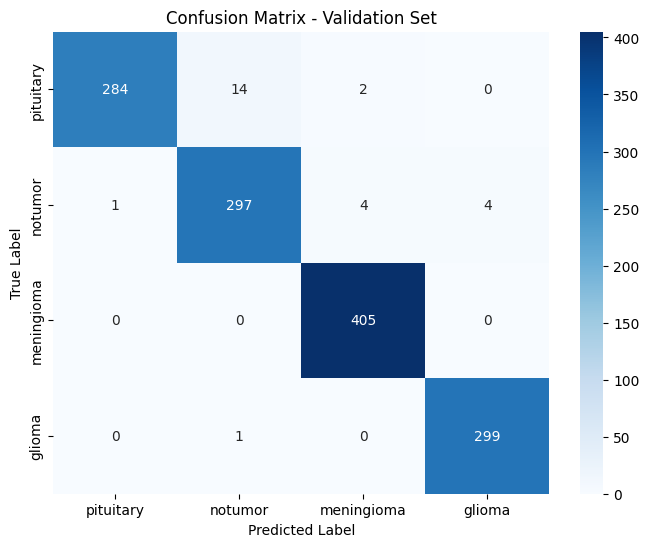

In [109]:
# Confusion matrix for validation set
cm = confusion_matrix(test_true_labels, test_predictions_classes)

# Plot confusion matrix for validation set
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()